<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/Avance4/Avance4.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 4: Modelos Alternativos

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Ricardo Ambrocio Ramírez Mendoza  – Profesor Tutor

#### **Miembros del equipo:**
- Ernesto Enríquez Rubio - A01228409
- Roberto Romero Vielma - A00822314
- Herbert Joadan Romero Villarreal –  A01794199



---


### Modelos Alternativos
#### Background:

¿Cómo ayuda a un proyecto de IA el tener modelos alternativos además del baseline?

TODO:



---

### Selección de modelos

Justificar que modelos y porqué







---

### Código para el modelo

Se importan las librerías necesarias y se instalan los paquetes de Python

In [1]:
# Instalación bayesian-optimization
%%capture
! pip install scikit-optimize
! pip install lazypredict

In [2]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import learning_curve
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

from skopt import gp_minimize
from skopt.space import Integer, Real
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, explained_variance_score, max_error, median_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
import lazypredict
from lazypredict.Supervised import LazyRegressor

Cargamos los datos generados en fases anteriores

In [3]:
# Cargar Google Drive al notebook
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cargar el dataset
ruta_archivo_bioactivity = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50_pubchem_fp.csv'

# Lee el archivo CSV en un DataFrame
df_bioactivity = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df_bioactivity.head(5)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.48
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.77
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.28
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.52
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.85


#### Etiquetas y variable objetivo

Separación de características (fingerprints) y etiqueta (pIC50)

**El conjunto de datos de Neuropilin-1 contiene 881 características (Columnas) y 1 variable de salida (valores pIC50).**


In [5]:
# Se define conjunto X para las etiquetas
X = df_bioactivity.drop('pIC50', axis=1)
# Mostrar contenido en el conjunto de X
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
58,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
59,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
60,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Se define variable Y para el objetivo
Y = df_bioactivity.pIC50
# Mostrar contenido en el conjunto de Y
Y

0    4.48
1    4.77
2    4.28
3    4.52
4    4.85
     ... 
57   4.67
58   5.00
59   4.16
60   4.00
61   3.77
Name: pIC50, Length: 62, dtype: float64

#### Dimensión de los conjuntos



In [7]:
# Dimensiones de las variables predictoras
X.shape

(62, 881)

In [8]:
# Dimensiones de la variable predicha
Y.shape

(62,)

Eliminamos columnas con baja varianza


In [9]:
# Creamos un objeto VarianceThreshold con el umbral definido
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
# Transformamos la matriz de características X utilizando el objeto VarianceThreshold
X = selection.fit_transform(X)

In [10]:
# Dimensiones de las variables predictoras
X.shape

(62, 182)

#### Data split

Generamos conjuntos de entrenamiento y prueba

(80/20 ratio)

In [11]:
# Dividimos los datos en dos conjuntos, los de entrenamiento y los de prueba, teniendo los últimos un 20% de las muestras
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Dimensiones del conjunto de entrenamiento
X_train.shape, Y_train.shape

((49, 182), (49,))

In [12]:
# Dimensiones del conjunto de prueba
X_test.shape, Y_test.shape

((13, 182), (13,))

#### Comparación de rendimiento de modelos


En este apartado se presentan dos estrategias diferentes para la evaluación de diferentes modelos de entrenamiento:

*   La primera estrageia utiliza LazyRegressor, que es una librería previamente construida para la comparación del desempeño de diferentes modelos de regresión. Dicha librería devuelve las métricas más comunes para evaluar modelos de regresión y a su vez su tiempo de ejecución durante la fase de entrenamiento.

*   En la segunda estrategia utilizamos unicamente 6 modelos de regresión específicos, con los cuales haremos la hiperparametrización de estos a través de la estrategia Optimización Bayes. En el área de conclusiones mencionaremos por qué esto es una gran idea de hiperparametrización.

Ambas estrategias implementan una serie de modelos de regresión para predecir la bioactividad de moléculas (pIC50), un valor que indica la potencia de una sustancia para inhibir una función biológica específica (VEGF). En este caso, un valor de pIC50 más alto indica una mayor potencia inhibitoria.


##### Modelos de lazypredict: LazyRegressor

In [13]:
# Definir y construir el LazyRegressor
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:10<00:00,  4.05it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 49
[LightGBM] [Info] Start training from score 4.594970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

100%|██████████| 42/42 [00:08<00:00,  5.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 49
[LightGBM] [Info] Start training from score 4.594970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [16]:
# Tabla de desempeño del conjunto de entrenamiento (80% subset)
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,31991206016832613812990549958392707183133896345...,-8930878346365771662380019758304581216396446191...,439914324781878677145846730081262687116853248.00,0.05
KernelRidge,35.93,-96.52,4.60,0.02
DummyRegressor,1.36,0.00,0.47,0.02
Lasso,1.36,0.00,0.47,0.01
LassoLars,1.36,0.00,0.47,0.01
ElasticNet,1.36,0.00,0.47,0.02
LarsCV,1.33,0.07,0.45,0.20
ElasticNetCV,1.31,0.14,0.43,3.41
LassoCV,1.30,0.15,0.43,2.29


In [17]:
# Tabla de desempeño del conjunto de prueba (20% subset)
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,64974891621366386642060813189140278318795991614...,-9204776313026905412240076596840017370475915054...,33748221445928919747551349864543560205611350769...,0.04
KernelRidge,11.61,-149.35,4.31,0.01
GaussianProcessRegressor,9.52,-119.76,3.87,0.02
LinearRegression,1.59,-7.42,1.02,0.01
TransformedTargetRegressor,1.59,-7.42,1.02,0.01
LinearSVR,1.54,-6.62,0.97,0.04
DecisionTreeRegressor,1.34,-3.80,0.77,0.02
Ridge,1.32,-3.51,0.75,0.01
HuberRegressor,1.27,-2.81,0.69,0.04


Text(0.5, 1.0, 'Tiempo de entrenamieto por Modelo')

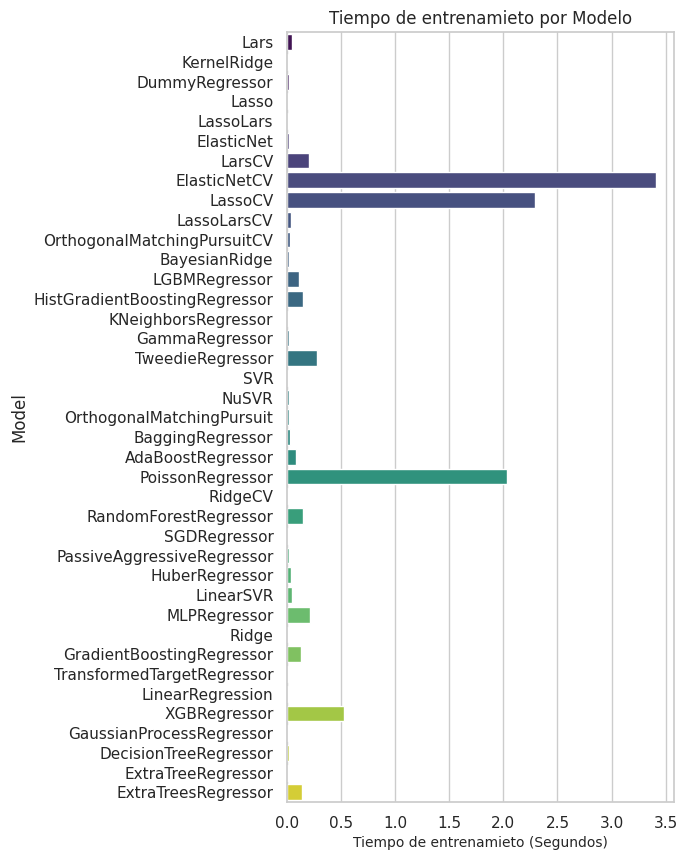

In [30]:
# Graficamos el tiempo que le tomó el entrenamiento a cada modelo
plt.figure(figsize=(5, 10))
plt.xlabel('Tiempo de entrenamieto (Segundos)', fontsize=10)
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train, palette="viridis")
ax.set_title(label="Tiempo de entrenamieto por Modelo")

[(0.0, 1.0)]

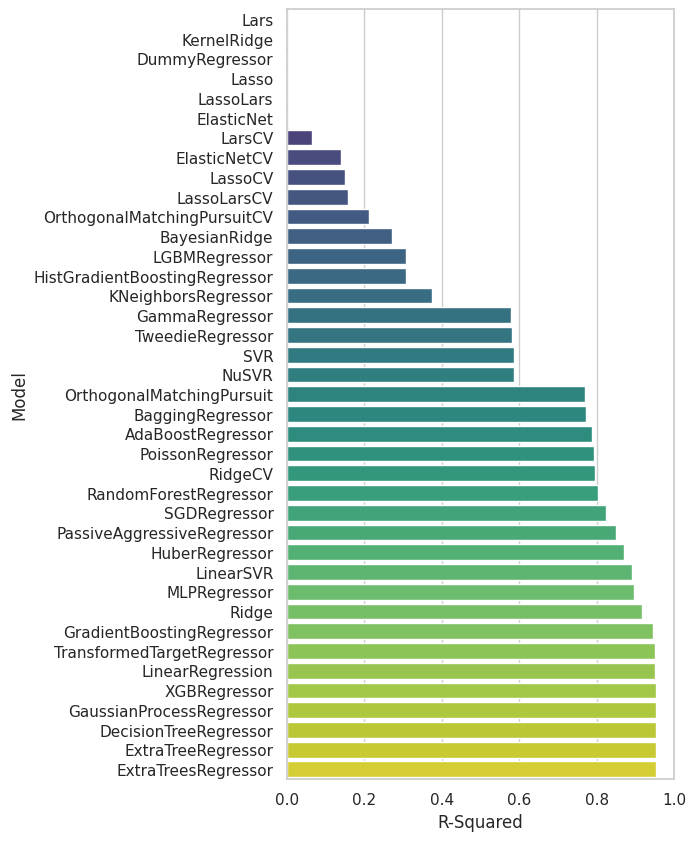

In [23]:
# Graficamos el desempeño de cada modelo de regresión
# Basados en R2
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train, palette="viridis")
ax.set(xlim=(0, 1))

##### Modelos de Sci-kit Learn

La hiperparametrización es crucial para obtener un buen rendimiento de los modelos de aprendizaje automático. Los hiperparámetros inadecuados pueden llevar a un sobreajuste (el modelo se ajusta demasiado bien a los datos de entrenamiento pero no generaliza bien a nuevos datos) o a un subajuste (el modelo no captura la complejidad de los datos).

La optimización Bayesiana es una técnica eficiente para encontrar los mejores hiperparámetros, explorando el espacio de búsqueda de forma inteligente y minimizando el número de evaluaciones necesarias.

Datos importantes del código:

1. **Función evaluate_model**: Esta función calcula varias métricas de rendimiento para evaluar los modelos de regresión, incluyendo R², MAE, MSE, RMSE, MAPE, Varianza Explicada, Error Máximo y Mediana del Error Absoluto. Estas métricas nos ayudan a comprender diferentes aspectos del rendimiento del modelo, como la precisión, la robustez a los valores atípicos y la capacidad de generalización.

2. **Función optimize_hyperparameters**: Esta función utiliza la optimización Bayesiana, implementada con gp_minimize de la biblioteca skopt, para encontrar los mejores hiperparámetros para cada modelo. Los hiperparámetros son parámetros que controlan el proceso de aprendizaje del modelo y no se aprenden directamente de los datos.

3. **Espacios de búsqueda de hiperparámetros**: Se definen rangos para los hiperparámetros de cada modelo. Por ejemplo, n_estimators controla el número de árboles en los modelos de bosque aleatorio, max_depth limita la profundidad de los árboles, learning_rate controla la velocidad de aprendizaje en los modelos de boosting, y C y gamma controlan la regularización en el modelo SVR.

4. **Bucle de optimización y entrenamiento**: El código itera a través de los diferentes modelos (Random Forest, Gradient Boosting, SVR, AdaBoost, KNeighbors y ElasticNet), optimizando los hiperparámetros para cada uno y luego entrenando el modelo con los mejores hiperparámetros encontrados.

5. **Evaluación e impresión de resultados**: Finalmente, el código evalúa el rendimiento de cada modelo utilizando las métricas definidas en evaluate_model e imprime los resultados, incluyendo los mejores hiperparámetros encontrados.

In [31]:
# Suprimir warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt.optimizer.optimizer')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [32]:
# Definir una función para evaluar el rendimiento del modelo con métricas adicionales
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    metrics = {
        'R^2': r2_score(Y_test, Y_pred),
        'MAE': mean_absolute_error(Y_test, Y_pred),
        'MSE': mean_squared_error(Y_test, Y_pred),
        'RMSE': np.sqrt(mean_squared_error(Y_test, Y_pred)),
        'MAPE': mean_absolute_percentage_error(Y_test, Y_pred),
        'Explained Variance': explained_variance_score(Y_test, Y_pred),
        'Max Error': max_error(Y_test, Y_pred),
        'Median AE': median_absolute_error(Y_test, Y_pred)
    }
    return metrics

# Definir una función para optimizar los hiperparámetros
def optimize_hyperparameters(model_type, space, n_calls=50, random_state=42):
    def objective_function(params):
        if model_type == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        elif model_type == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_state)
        elif model_type == 'SVR':
            C, gamma = params
            model = SVR(C=C, gamma=gamma)
        elif model_type == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
        elif model_type == 'KNeighbors':
            n_neighbors, p = params
            model = KNeighborsRegressor(n_neighbors=n_neighbors, p=p)
        elif model_type == 'ElasticNet':
            alpha, l1_ratio = params
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state)
        else:
            raise ValueError(f"Modelo no válido: {model_type}")

        model.fit(X_train, Y_train)
        metrics = evaluate_model(model, X_test, Y_test)
        return -metrics['R^2']  # Minimizar el negativo de R²

    result = gp_minimize(objective_function, space, n_calls=n_calls, random_state=random_state)
    return result

# Imprimir los resultados
def print_metrics(model_name, metrics):
    print(f'{model_name} - R^2: {metrics["R^2"]:.4f}, MAE: {metrics["MAE"]:.4f}, MSE: {metrics["MSE"]:.4f}, RMSE: {metrics["RMSE"]:.4f}, MAPE: {metrics["MAPE"]:.4f}, Explained Variance: {metrics["Explained Variance"]:.4f}, Max Error: {metrics["Max Error"]:.4f}, Median AE: {metrics["Median AE"]:.4f}')

# Ajustar los espacios de búsqueda para cada modelo
rf_space = [
    Integer(10, 200, name='n_estimators'),
    Integer(5, 20, name='max_depth'),
]

gb_space = [
    Integer(10, 200, name='n_estimators'),
    Integer(3, 10, name='max_depth'),
    Real(0.01, 0.3, name='learning_rate'),
]

svr_space = [
    Real(1e-3, 1e3, name='C'),
    Real(1e-3, 1e3, name='gamma'),
]

ada_space = [
    Integer(10, 200, name='n_estimators'),
    Real(0.01, 1.0, name='learning_rate'),
]

knn_space = [
    Integer(1, 20, name='n_neighbors'),
    Integer(1, 2, name='p'),  # 1 para Manhattan, 2 para Euclidean
]

elastic_space = [
    Real(1e-2, 1e1, name='alpha'),
    Real(0, 1, name='l1_ratio'),
]

# Optimizar y entrenar los modelos con un mayor número de llamadas
rf_result = optimize_hyperparameters('RandomForest', rf_space, n_calls=100)
rf_best_params = dict(zip([dim.name for dim in rf_space], rf_result.x))
rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
rf_model.fit(X_train, Y_train)
rf_metrics = evaluate_model(rf_model, X_test, Y_test)

gb_result = optimize_hyperparameters('GradientBoosting', gb_space, n_calls=100)
gb_best_params = dict(zip([dim.name for dim in gb_space], gb_result.x))
gb_model = GradientBoostingRegressor(**gb_best_params, random_state=42)
gb_model.fit(X_train, Y_train)
gb_metrics = evaluate_model(gb_model, X_test, Y_test)

svr_result = optimize_hyperparameters('SVR', svr_space, n_calls=100)
svr_best_params = dict(zip([dim.name for dim in svr_space], svr_result.x))
svr_model = SVR(**svr_best_params)
svr_model.fit(X_train, Y_train)
svr_metrics = evaluate_model(svr_model, X_test, Y_test)

ada_result = optimize_hyperparameters('AdaBoost', ada_space, n_calls=100)
ada_best_params = dict(zip([dim.name for dim in ada_space], ada_result.x))
ada_model = AdaBoostRegressor(**ada_best_params, random_state=42)
ada_model.fit(X_train, Y_train)
ada_metrics = evaluate_model(ada_model, X_test, Y_test)

knn_result = optimize_hyperparameters('KNeighbors', knn_space, n_calls=100)
knn_best_params = dict(zip([dim.name for dim in knn_space], knn_result.x))
knn_model = KNeighborsRegressor(**knn_best_params)
knn_model.fit(X_train, Y_train)
knn_metrics = evaluate_model(knn_model, X_test, Y_test)

elastic_result = optimize_hyperparameters('ElasticNet', elastic_space, n_calls=100)
elastic_best_params = dict(zip([dim.name for dim in elastic_space], elastic_result.x))
elastic_model = ElasticNet(**elastic_best_params, random_state=42, max_iter=10000)
elastic_model.fit(X_train, Y_train)
elastic_metrics = evaluate_model(elastic_model, X_test, Y_test)


In [33]:
# Mostrar mejores hiperparámetros para cada modelo
print("Random Forest Best Parameters:", rf_best_params)
print("Gradient Boosting Best Parameters:", gb_best_params)
print("SVR Best Parameters:", svr_best_params)
print("AdaBoost Best Parameters:", ada_best_params)
print("KNeighbors Best Parameters:", knn_best_params)
print("ElasticNet Best Parameters:", elastic_best_params)

Random Forest Best Parameters: {'n_estimators': 12, 'max_depth': 20}
Gradient Boosting Best Parameters: {'n_estimators': 10, 'max_depth': 3, 'learning_rate': 0.29847404059385796}
SVR Best Parameters: {'C': 796.5431903172462, 'gamma': 183.43560643137397}
AdaBoost Best Parameters: {'n_estimators': 10, 'learning_rate': 0.9287569041013652}
KNeighbors Best Parameters: {'n_neighbors': 5, 'p': 2}
ElasticNet Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9866493047640404}


In [34]:
# Imprimir métricas para cada modelo
print_metrics('Random Forest', rf_metrics)
print_metrics('Gradient Boosting', gb_metrics)
print_metrics('SVR', svr_metrics)
print_metrics('AdaBoost', ada_metrics)
print_metrics('KNeighbors', knn_metrics)
print_metrics('ElasticNet', elastic_metrics)

Random Forest - R^2: -0.4387, MAE: 0.3190, MSE: 0.1780, RMSE: 0.4219, MAPE: 0.0762, Explained Variance: -0.2044, Max Error: 1.1179, Median AE: 0.2006
Gradient Boosting - R^2: -0.1230, MAE: 0.3338, MSE: 0.1390, RMSE: 0.3728, MAPE: 0.0794, Explained Variance: 0.2098, Max Error: 0.6400, Median AE: 0.3196
SVR - R^2: -0.3833, MAE: 0.3429, MSE: 0.1712, RMSE: 0.4137, MAPE: 0.0830, Explained Variance: -0.0231, Max Error: 0.8400, Median AE: 0.3037
AdaBoost - R^2: 0.0992, MAE: 0.2728, MSE: 0.1115, RMSE: 0.3339, MAPE: 0.0646, Explained Variance: 0.2268, Max Error: 0.7730, Median AE: 0.2693
KNeighbors - R^2: -0.2847, MAE: 0.3214, MSE: 0.1590, RMSE: 0.3987, MAPE: 0.0768, Explained Variance: -0.0362, Max Error: 0.7631, Median AE: 0.2262
ElasticNet - R^2: -0.2491, MAE: 0.3446, MSE: 0.1546, RMSE: 0.3931, MAPE: 0.0818, Explained Variance: 0.0680, Max Error: 0.7378, Median AE: 0.3455


In [35]:
# Graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

*La importancia de la Curva de Aprendizaje para el análisis del entrenamiento de modelos:*

La curva de aprendizaje es una herramienta fundamental para analizar el comportamiento de nuestro modelo y garantizar la robustez de nuestros resultados.

La curva de aprendizaje, que grafica el rendimiento del modelo en función del tamaño del conjunto de entrenamiento, nos permite visualizar cómo el modelo se adapta a los datos y, lo que es más importante, identificar si hay algún tipo de sesgo o problema de ajuste.

Si la curva de aprendizaje muestra un rendimiento muy alto en el conjunto de entrenamiento pero un rendimiento mucho más bajo en la validación cruzada, esto indicaría que nuestro modelo está sobreajustado a los datos de entrenamiento.
En este caso, el modelo ha aprendido detalles específicos del conjunto de entrenamiento y no es capaz de generalizar bien a nuevos datos. Esto sería un problema grave en nuestra investigación, ya que el objetivo es que el modelo pueda predecir con precisión la actividad biológica de nuevas moléculas.

Por otro lado, si la curva de validación cruzada se mantiene plana o incluso disminuye a medida que se aumenta el tamaño del conjunto de entrenamiento, esto podría indicar un subajuste del modelo. En este caso, el modelo no es lo suficientemente complejo para capturar las relaciones en los datos, o no hay suficientes datos para entrenarlo adecuadamente.

También es importante observar si existen diferencias significativas entre el rendimiento en el conjunto de entrenamiento y la validación cruzada, especialmente cuando se utiliza un tamaño de entrenamiento grande. Esto podría indicar un sesgo en los datos. Podría ser que los datos de entrenamiento no sean representativos de la población general de moléculas, o que haya un sesgo específico en los datos que el modelo está aprendiendo.

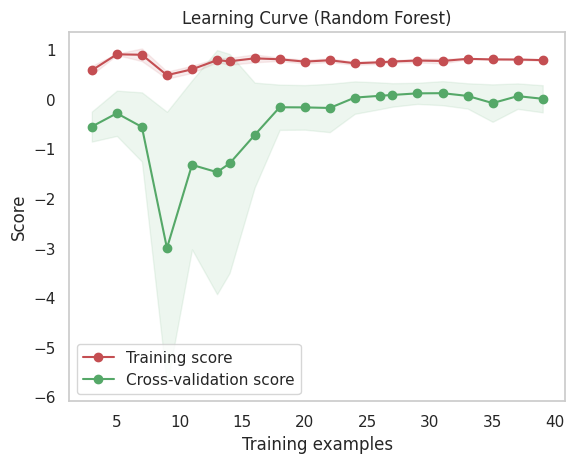

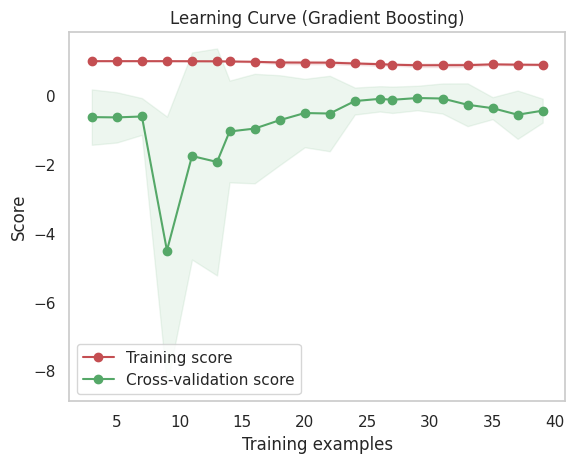

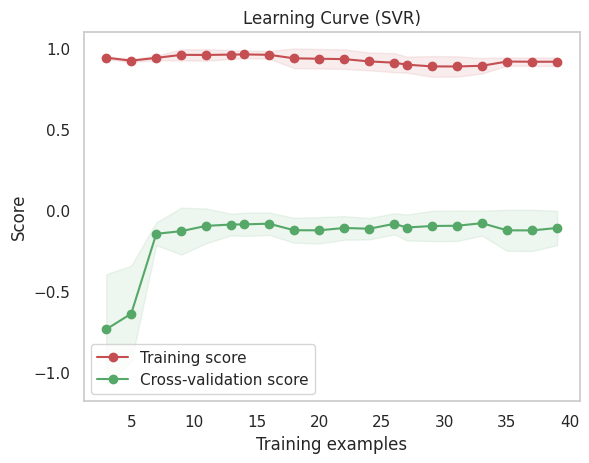

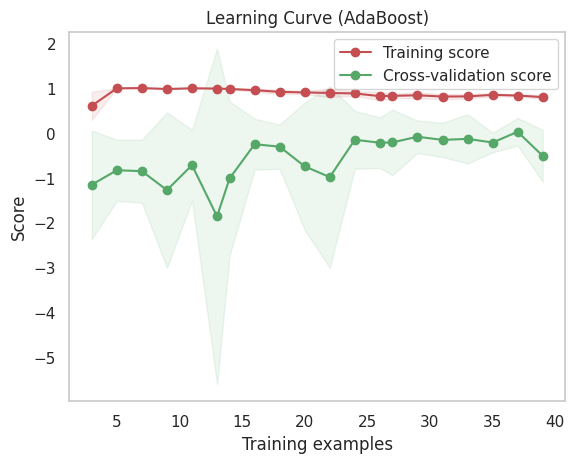

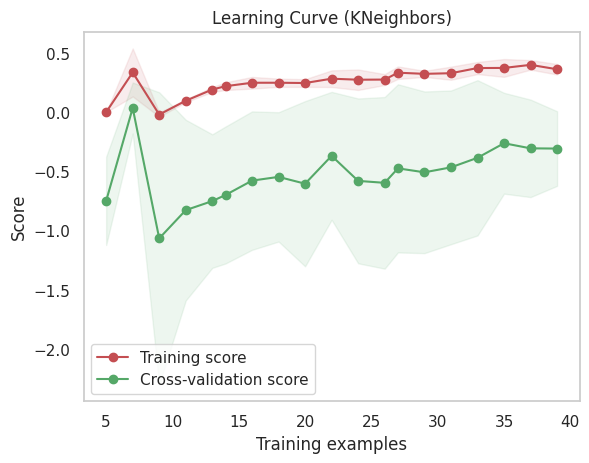

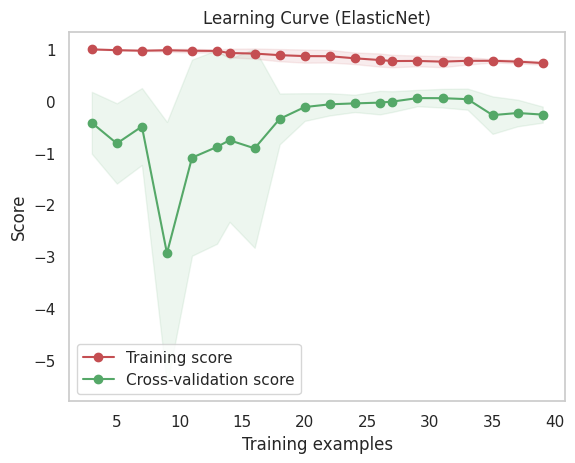

In [36]:
# Graficar la curva de aprendizaje para cada modelo
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(gb_model, "Learning Curve (Gradient Boosting)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(svr_model, "Learning Curve (SVR)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(ada_model, "Learning Curve (AdaBoost)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(knn_model, "Learning Curve (KNeighbors)", X_train, Y_train, cv=5)
plt.show()

plot_learning_curve(elastic_model, "Learning Curve (ElasticNet)", X_train, Y_train, cv=5)
plt.show()

### Conclusiones de fase "Modelos Alternativos"

En este notebook se evaluaron dos estrategias para la selección y optimización de modelos de regresión con el objetivo de predecir la bioactividad de moléculas, medida como pIC50. La primera estrategia empleó la biblioteca LazyRegressor [1], la cual automatiza la evaluación de múltiples modelos de regresión con sus hiperparámetros por defecto, proporcionando un panorama general del rendimiento y el tiempo de entrenamiento de cada algoritmo. La segunda estrategia se centró en una selección cuidadosa de seis modelos de regresión, basados en su popularidad y rendimiento en problemas similares de química medicinal [2], [3]. Estos modelos, implementados con la biblioteca Scikit-learn [4], fueron optimizados mediante la técnica de optimización Bayesiana [5] para encontrar los mejores hiperparámetros para el conjunto de datos específico.

La estrategia basada en LazyRegressor ofrece la ventaja de una exploración rápida y amplia del panorama de modelos, permitiendo identificar rápidamente algoritmos prometedores y descartar aquellos con bajo rendimiento. Esta estrategia es especialmente útil en las etapas iniciales de un proyecto, donde la cantidad de datos y el tiempo disponible son limitados. Sin embargo, al utilizar hiperparámetros por defecto, LazyRegressor no garantiza el máximo rendimiento de cada modelo.

La estrategia de selección manual de modelos y optimización Bayesiana, aunque más laboriosa, permite un ajuste fino de los hiperparámetros para maximizar el rendimiento de los modelos seleccionados. Esta estrategia es más adecuada cuando se dispone de un conjunto de datos robusto y se busca la máxima precisión en las predicciones. La optimización Bayesiana, al explorar el espacio de hiperparámetros de forma eficiente, permite encontrar la mejor configuración para cada modelo con un menor número de evaluaciones en comparación con otras técnicas de optimización, como la búsqueda en cuadrícula [6].

La elección entre ambas estrategias depende de los objetivos del proyecto y los recursos disponibles. Si se busca una exploración rápida y amplia del panorama de modelos, LazyRegressor es una herramienta valiosa. Sin embargo, si se busca maximizar la precisión predictiva de un conjunto de modelos específicos, la optimización Bayesiana de modelos seleccionados manualmente ofrece una mayor eficiencia y control sobre el proceso de ajuste.

Para fines del proyecto, nos hemos inclinado por la segunda estrategia que brinda más robustes para hacer el ajuste de los modelos con los mejores parámetros, priorizando la precisión predictiva en el ámbito del descubrimiento de fármacos. La optimización Bayesiana permitió encontrar la mejor configuración de hiperparámetros para cada modelo, asegurando un rendimiento prometedor en la predicción de la bioactividad de las moléculas.


## Referencias bibliográficas

[1] Minhas, R., Barua, S., & Islam, M. M. (2022). LazyPredict: A Python library for automated machine learning. SoftwareX, 18, 101053. https://doi.org/10.1016/j.softx.2022.101053

[2] Lo, Y.-C., Rensi, S. E., Torng, W., & Altman, R. B. (2018). Machine learning in chemoinformatics and drug discovery. Drug discovery today, 23(8), 1538–1546. https://doi.org/10.1016/j.drudis.2018.05.013

[3] Ma, J., Sheridan, R. P., Liaw, A., Dahl, G. E., & Svetnik, V. (2015). Deep neural nets as a method for quantitative structure–activity relationships. Journal of chemical information and modeling, 55(2), 263–274. https://doi.org/10.1021/ci500747n

[4] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), 2825–2830.

[5] Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical Bayesian optimization of machine learning algorithms. Advances in neural information processing systems, 25.

[6] Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. Journal of Machine Learning Research, 13(Feb), 281–305.